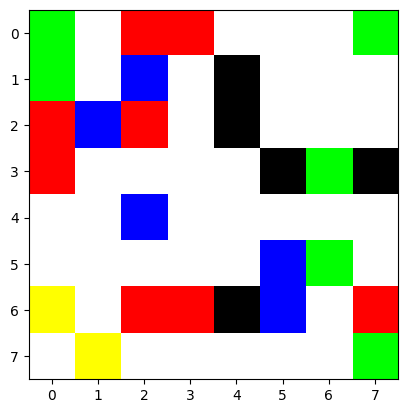

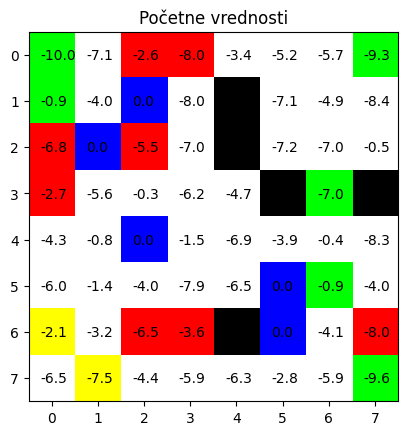

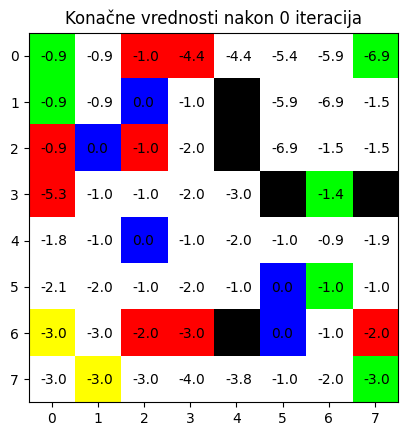

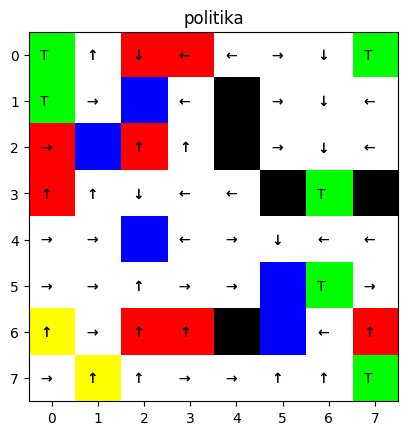

In [ ]:
from abc import ABC, abstractmethod
from typing import Iterable, Callable
from copy import copy

import numpy as np
import matplotlib.pyplot as plt

from random import random, choices

# Definicija bazne klase za ćelije
class Cell(ABC):
    @abstractmethod
    def get_reward(self) -> float:
        pass

    def is_steppable(self) -> bool:
        return True

    def is_terminal(self) -> bool:
        return False

    def has_value(self) -> bool:
        return True

# Implementacija RegularCell, TerminalCell i WallCell
class RegularCell(Cell):
    def __init__(self, reward: float):
        self.reward = reward

    def get_reward(self) -> float:
        return self.reward

class TerminalCell(Cell):
    def __init__(self, reward: float):
        self.reward = reward

    def get_reward(self) -> float:
        return self.reward

    def is_terminal(self) -> bool:
        return True

    def has_value(self) -> bool:
        return False

class WallCell(Cell):
    def get_reward(self) -> float:
        return 0

    def is_steppable(self) -> bool:
        return False

    def has_value(self) -> bool:
        return False

# Implementacija TeleportCell
class TeleportCell(Cell):
    def __init__(self, row: int, col: int, linked_cell: tuple[int, int]):
        self.row = row
        self.col = col
        self.linked_cell = linked_cell

    def get_reward(self) -> float:
        return 0

    def is_steppable(self) -> bool:
        return True

    def has_value(self) -> bool:
        return False

# Implementacija MazeBoard
class MazeBoard:
    @staticmethod
    def validate_cells(cells: Iterable[Iterable[Cell]]) -> tuple[int, int, list[list[Cell]]]:
        cells = [list(row) for row in cells] if cells else []
        if not cells:
            raise Exception("Number of rows in a board must be at least one.")
        if not cells[0]:
            raise Exception("There has to be at least one column.")
        rows_no = len(cells)
        cols_no = len(cells[0])
        for row in cells:
            if not row or len(row) != cols_no:
                raise Exception(
                    "Each row in a a board must have the same number of columns. ")
        return rows_no, cols_no, cells

    def __init__(self, cells: Iterable[Iterable[Cell]]):
        rows_no, cols_no, cells = MazeBoard.validate_cells(cells)
        self.cells = cells
        self.rows_no = rows_no
        self.cols_no = cols_no

    def __getitem__(self, key: tuple[int, int]) -> Cell:
        r, c = key
        return self.cells[r][c]

# Implementacija funkcija za generisanje i prikazivanje slučajnih tabli
CellGenerator = Callable[[], Cell]

def create_random_board(size: tuple[int, int], specs=list[tuple[float, CellGenerator]]) -> MazeBoard:
    h, w = size
    weights = [w for w, _ in specs]
    generators = [g for _, g in specs]
    random_cell = lambda: choices(generators, weights, k=1)[0]()
    cells = [[random_cell() for i in range(w)] for j in range(h)]
    return MazeBoard(cells)

def default_cell_color(cell: Cell) -> tuple[int, int, int]:
    if isinstance(cell, RegularCell):
        if cell.get_reward() == -1:
            return (255, 255, 255)  # Regular cell
        else:
            return (255, 0, 0)  # Regular cell with penalty
    elif isinstance(cell, WallCell):
        return (0, 0, 0)  # Wall cell
    elif isinstance(cell, TeleportCell):
        return (0, 255, 0)  # Teleport cell
    else:
        return (0, 0, 255)  # Terminal cell

def draw_board(board: MazeBoard, color = default_cell_color, pos: tuple[int, int] = None, ax=None):
    ax = ax if ax is not None else plt
    board_img = np.ones(shape=(board.rows_no, board.cols_no, 3), dtype=np.uint8)
    for i in range(board.rows_no):
        for j in range(board.cols_no):
            board_img[i, j, :] = color(board[i, j])
    if pos is not None:
        row, col = pos
        ax.text(col-0.25, row+0.1, "X", fontweight="bold")
    if ax is not None:
        ax.imshow(board_img)
    else:
        plt.imshow(board_img)

def draw_values(env, values, ax=None):
    ax = ax if ax is not None else plt
    draw_board(env.board, ax=ax)
    for s in values:
        ax.text(s[1]-0.25, s[0]+0.1, f"{values[s]:.1f}")

RIGHT = 0
UP = 1
LEFT = 2
DOWN = 3

ACTIONS = ["RIGHT", "UP", "LEFT", "DOWN"]
class MazeEnvironment:
    def __init__(self, board: MazeBoard):
        self.board = board

    def validate_position(self, row, col):
        if row < 0 or row >= self.rows_no:
            raise Exception("Invalid row position.")
        if col < 0 or col >= self.cols_no:
            raise Exception("Invalid column position.")
        if not self.board[row, col].is_steppable():
            raise Exception("Invalid position: unsteppable cell.")
        return row, col

    def move_up_from(self, row: int, col: int) -> tuple[int, int]:
        if row != 0 and self.board[row-1, col].is_steppable():
            return row-1, col
        else:
            return row, col

    def move_down_from(self, row: int, col: int) -> tuple[int, int]:
        if row != self.board.rows_no-1 and self.board[row+1, col].is_steppable():
            return row+1, col
        else:
            return row, col

    def move_left_from(self, row: int, col: int) -> tuple[int, int]:
        if col != 0 and self.board[row, col-1].is_steppable():
            return row, col-1
        else:
            return row, col

    def move_right_from(self, row: int, col: int) -> tuple[int, int]:
        if col != self.board.cols_no-1 and self.board[row, col+1].is_steppable():
            return row, col+1
        else:
            return row, col

    def move_from(self, row: int, col: int, action: int) -> tuple[int, int]:
        cell = self.board[row, col]
        if isinstance(cell, TeleportCell) and cell.linked_cell:
            # Ako je igrač na povezanoj Teleport ćeliji, prelazi na povezanu Teleport ćeliju
            return cell.linked_cell
        else:
            # Inače, obavlja se uobičajeno kretanje
            if action == RIGHT:
                return self.move_right_from(row, col)
            elif action == UP:
                return self.move_up_from(row, col)
            elif action == LEFT:
                return self.move_left_from(row, col)
            elif action == DOWN:
                return self.move_down_from(row, col)
            else:
                raise Exception("Neispravna akcija.")

    def __call__(self, state: tuple[int, int], action: int) -> tuple[tuple[int, int], float, bool]:
        row, col = state
        new_row, new_col = self.move_from(row, col, action)
        new_cell = self.board[new_row, new_col]
        reward = new_cell.get_reward()
        is_terminal = new_cell.is_terminal()
        return (new_row, new_col), reward, is_terminal

    def get_states(self):
        states = []
        for r in range(self.board.rows_no):
            for c in range(self.board.cols_no):
                if self.board[r, c].is_steppable():
                    states.append((r, c))
        return states

    def is_terminal(self, s):
        return self.board[s[0], s[1]].is_terminal()

    def get_actions(self):
        return [RIGHT, UP, LEFT, DOWN]

def update_state_value(env: MazeEnvironment, s, v, gamma):
    """Ažurira vrednost datog stanja."""
    rhs = []
    for a in env.get_actions():
        s_new, r, _ = env(s, a)
        rhs.append(r + gamma*v[s_new])
    return max(rhs)

def async_update_all_values(env: MazeEnvironment, v, gamma):
    """Ažurira vrednosti svih stanja."""
    for s in env.get_states():
        if not env.is_terminal(s):
            v[s] = update_state_value(env, s, v, gamma)
    return copy(v)

def init_values(env):
    """Slučajno inicijalizuje vrednosti stanja u datom okruženju."""
    values = {s: -10*random.random() for s in env.get_states()}

    for s in values:
        if env.is_terminal(s):
            values[s] = 0

    return values


def default_cell_color(cell: Cell) -> tuple[int, int, int]:
    """Dodeljuje boju ćelijama u zavisnosti od tipa."""
    if isinstance(cell, RegularCell):
        if cell.get_reward() == -1:
            return (255, 255, 255)  # Regularna ćelija
        else:
            return (255, 0, 0)  # Regularna ćelija sa kaznom
    elif isinstance(cell, WallCell):
        return (0, 0, 0)  # Zidna ćelija
    elif isinstance(cell, TeleportCell):
        # Boja Teleport ćelija
        if cell.linked_cell:
            return (255, 255, 0)  # Žuta boja za povezane Teleport ćelije
        else:
            return (0, 255, 0)  # Zelena boja za nepovezane Teleport ćelije
    else:
        return (0, 0, 255)  # Terminalna ćelija


"""def draw_board(board: MazeBoard, color_function=default_cell_color, pos: tuple[int, int] = None, ax=None):
    #Vizualizuje lavirint.
    ax = ax if ax is not None else plt
    board_img = np.ones(shape=(board.rows_no, board.cols_no, 3), dtype=np.uint8)
    for i in range(board.rows_no):
        for j in range(board.cols_no):
            board_img[i, j, :] = color_function(board[i, j])
    if pos is not None:
        row, col = pos
        ax.text(col-0.1, row+0.1, "X", fontweight="bold")
    if ax is not None:
        ax.imshow(board_img)
    else:
        plt.imshow(board_img)"""

def draw_board(board: MazeBoard, color_function=default_cell_color, pos: tuple[int, int] = None, ax=None):
    """Vizualizuje lavirint."""
    ax = ax if ax is not None else plt
    board_img = np.ones(shape=(board.rows_no, board.cols_no, 3), dtype=np.uint8)
    for i in range(board.rows_no):
        for j in range(board.cols_no):
            cell = board[i, j]
            # Prikaz Teleport ćelija sa povezanim Teleport ćelijama žutom bojom
            if isinstance(cell, TeleportCell) and cell.linked_cell:
                board_img[i, j, :] = (255, 255, 0)  # Žuta boja za povezane Teleport ćelije
            else:
                board_img[i, j, :] = color_function(cell)
            # Prikaz oznake za akciju na Teleport ćelijama
            if isinstance(cell, TeleportCell) and not cell.linked_cell:
                ax.text(j-0.1, i+0.1, "", fontweight="bold")
    if pos is not None:
        row, col = pos
        ax.text(col-0.1, row+0.1, "X", fontweight="bold")
    if ax is not None:
        ax.imshow(board_img)
    else:
        plt.imshow(board_img)




# Ispravljena inicijalizacija TeleportCell u funkciji create_random_board_with_teleports
import random

# Prilagođena implementacija funkcije za generisanje lavirinta sa teleportskim ćelijama
def create_random_board_with_teleports(size: tuple[int, int], teleport_count: int) -> 'MazeBoard':
    if teleport_count < 1:
        raise ValueError("At least one teleport cell is required.")

    # Generisanje slučajnih pozicija za teleportske ćelije
    teleports = [(random.randint(0, size[0]-1), random.randint(0, size[1]-1)) for _ in range(teleport_count)]

    # Odabir jedne teleportske ćelije kao ulazne, ostale će biti izlazne
    entry_teleport_index = random.randint(0, teleport_count-1)
    entry_teleport = teleports.pop(entry_teleport_index)

    # Kreiranje specifikacija za kreiranje lavirinta
    specs = [
        (10, lambda: RegularCell(-1)),
        (2, lambda: RegularCell(-10)),
        (2, lambda: WallCell()),
        (1, lambda: TerminalCell(-1)),
    ]

    # Dodavanje ulazne teleportske ćelije
    specs.append((1, lambda: TeleportCell(entry_teleport[0], entry_teleport[1], None)))

    # Dodavanje izlaznih teleportskih ćelija
    for teleport in teleports:
        specs.append((1, lambda: TeleportCell(teleport[0], teleport[1], entry_teleport)))

    # Kreiranje lavirinta
    return create_random_board(size, specs)

def find_terminal(env):
    """Pronalazi poziciju terminalne (plave) ćelije u okruženju."""
    for r in range(env.board.rows_no):
        for c in range(env.board.cols_no):
            if isinstance(env.board.cells[r][c], TerminalCell):
                return r, c
    raise ValueError("Terminal cell not found in the environment.")

# Izmenjena funkcija action_symbol
def action_symbol(a, cell, env, show_T=False):
    if isinstance(cell, TeleportCell):
        if not cell.linked_cell:
            return "" if not show_T else "T"
        else:
            linked_row, linked_col = cell.linked_cell
            terminal_row, terminal_col = find_terminal(env)
            if terminal_row > linked_row:
                return "↓"
            elif terminal_row < linked_row:
                return "↑"
            elif terminal_col > linked_col:
                return "→"
            elif terminal_col < linked_col:
                return "←"
            else:
                return "T"
    elif a == RIGHT:
        return "→"
    elif a == UP:
        return "↑"
    elif a == LEFT:
        return "←"
    elif a == DOWN:
        return "↓"
    else:
        raise Exception("Unknown action")







# Izmenjena funkcija draw_policy
def draw_policy(env, policy, ax=None):
    """Vizualizuje politiku."""
    ax = ax if ax is not None else plt
    draw_board(env.board, ax=ax)
    teleports_visited = set()
    for s, a in policy.items():
        cell = env.board[s[0], s[1]]
        if isinstance(cell, TeleportCell):
            ax.text(s[1]-0.25, s[0]+0.1, action_symbol(a, cell, env, show_T=True))
        else:
            ax.text(s[1]-0.25, s[0]+0.1, action_symbol(a, cell, env))


    # Crtanje politike
    for s, a in policy.items():
        cell = env.board.cells[s[0]][s[1]]
        ax.text(s[1]-0.25, s[0]+0.1, action_symbol(a, cell, env))

    plt.title("politika")
    plt.show()


# Inicijalizacija lavirinta sa teleportskim ćelijama
board_with_teleports = create_random_board_with_teleports((8, 8), 2)

# MDP okruženje za lavirint sa teleportskim ćelijama
env_with_teleports = MazeEnvironment(board_with_teleports)





# Vizualizacija lavirinta
draw_board(board_with_teleports)
plt.show()


# Inicijalizacija vrednosti za Value Iteration
values_vi = init_values(env_with_teleports)

def draw_values(env, values, ax=None):
    ax = ax if ax is not None else plt
    draw_board(env.board, ax=ax)
    for s in values:
        ax.text(s[1]-0.25, s[0]+0.1, f"{values[s]:.1f}")

# Vizualizacija početnih vrednosti
draw_values(env_with_teleports, values_vi)
plt.title("Početne vrednosti")
plt.show()

def value_iteration(env, gamma, eps, v0=None, maxiter=100):
    v = v0 if v0 is not None else init_values(env)
    for k in range(maxiter):
        nv = async_update_all_values(env, values_vi, gamma)
        err = max([abs(nv[s] - v[s]) for s in v])
        if err<eps:
            return nv, k
        v = nv
    return v, k

# Asinhrona iteracija vrednosti
values_vi_final, k_vi = value_iteration(env_with_teleports, 1.0, 0.01, v0=values_vi, maxiter=100)

# Vizualizacija konačnih vrednosti
draw_values(env_with_teleports, values_vi_final)
plt.title(f"Konačne vrednosti nakon {k_vi} iteracija")
plt.show()

def greedy_action(env, s, v, gamma):
    vs = []
    for a in env.get_actions():
        s_next, _, _ = env(s, a)
        vs.append(v[s_next])
    return np.argmax(vs)

def optimal_policy(env, v, gamma):
    return {s: greedy_action(env, s, v, gamma) for s in env.get_states() if not env.is_terminal(s)}

# Izračunavanje optimalne politike
values_vi_final, k_vi = value_iteration(env_with_teleports, 1.0, 0.01)
optimal_pi = optimal_policy(env_with_teleports, values_vi_final, 1.0)

# Vizualizacija politike
draw_policy(env_with_teleports, optimal_pi)




In [ ]:
# Struktura podataka za čuvanje Q-vrednosti
class QValues:
    def __init__(self, env):
        self.q_values = {}
        for s in env.get_states():
            for a in env.get_actions():
                self.q_values[(s, a)] = random.random()  # Slučajne početne vrednosti


In [ ]:
# Ažuriranje Q-vrednosti koristeći asinhroni Q-learning
def async_update_all_q_values(env, q_values, gamma):
    """Ažurira sve Q-vrednosti u okruženju koristeći asinhroni Q-learning."""
    nq_values = {}
    for s in env.get_states():
        for a in env.get_actions():
            nq_values[(s, a)] = 0
            for s_next in env.get_states():
                transition_prob = 1 if s_next in env.get_next_states(s, a) else 0  # Koristi get_next_states
                reward = env.reward(s, a, s_next)
                nq_values[(s, a)] += transition_prob * (
                    reward + gamma * max(q_values[(s_next, a_next)] for a_next in env.get_actions())
                )
    return nq_values


# Ažuriranje vrednosti stanja koristeći Q-vrednosti
def update_state_value(env, s, q_values, gamma):
    """Ažurira vrednost datog stanja."""
    rhs = []
    for a in env.get_actions():
        s_next, r, _ = env(s, a)
        rhs.append(r + gamma*q_values.q_values[(s_next, a)])
    return max(rhs)

# Ažuriranje politike koristeći Q-vrednosti
def greedy_action(env, s, q_values, gamma):
    vs = []
    for a in env.get_actions():
        s_next, _, _ = env(s, a)
        vs.append(q_values.q_values[(s_next, a)])
    return np.argmax(vs)

def optimal_policy(env, q_values, gamma):
    return {s: greedy_action(env, s, q_values, gamma) for s in env.get_states() if not env.is_terminal(s)}


In [ ]:
def calc_max_change(q_values, nq_values, env):
    """Calculates the maximum absolute change between two Q-value dictionaries."""
    max_change = max(abs(nq_values[s, a] - q_values.q_values[s, a]) for s in q_values.q_values for a in env.get_actions())
    return max_change

# Implementacija iteracije vrednosti koristeći Q funkciju
def value_iteration_with_q(env, gamma, eps, q0=None, maxiter=100):
    q_values = q0 if q0 is not None else QValues(env)
    convergence_data = []
    for k in range(maxiter):
        nq = async_update_all_q_values(env, q_values, gamma)
        convergence_data.append(calc_max_change(q_values.q_values, nq, env))
        if convergence_data[-1] < eps:
            return nq, k
        q_values.q_values = nq
    return q_values, convergence_data


In [ ]:
# Vizualizacija konačnih Q-vrednosti
def visualize_q_values(q_values):
    """Vizualizacija konačnih Q-vrednosti."""
    for state_action, value in q_values.items():
        print(f"Q({state_action}) = {value}")

env_with_teleports = MazeEnvironment(board_with_teleports)
# Poziv algoritma i prikaz rezultata
env_with_teleports = MazeEnvironment(board_with_teleports)
q_values_final, convergence_data = value_iteration_with_q(env_with_teleports, 1.0, 0.01)
visualize_q_values(q_values_final)


AttributeError: 'MazeEnvironment' object has no attribute 'get_next_states'